## 왜? SAVE만 밤시간대에 사용량이 많을까...

## 난방 여부와의 분석

### * 데이터 로드 및 동일 집끼리 병합

In [4]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

# 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan

# 라벨 
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

In [13]:
helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

print('Done')

Done


In [15]:
def matching_id(data_df,label_df, q_id):
    valid_idx = ~pd.isnull(label_df.loc[q_id,:])
    label_df = label_df.loc[q_id, valid_idx]

    data_id = data_df.columns
    label_id = label_df.index

    valid_data, valid_label = [], []
    for i, id_ in enumerate(data_id):
        if id_ in label_id:
            valid_data.append(data_df[id_])
            valid_label.append(label_df[id_])
    valid_data = pd.concat(valid_data, axis=1)
    valid_label = np.array(valid_label)
    return valid_data, valid_label

data_f, label_f = matching_id(SAVE, SAVE_label, 'Q3_12')

### 전기난방과 아닌집의 conditional distribution

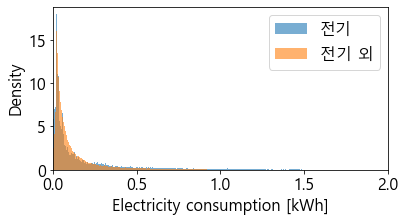

In [31]:
start_date = pd.to_datetime('2017-01-01 00:00:00')
end_date = pd.to_datetime('2017-02-01 23:00:00')

plt.figure(figsize = (6,3))
plt.hist(data_f.loc[start_date:end_date,label_f == 1].values.reshape(-1), label = '전기', bins = 1000, alpha = 0.6, density = True)
plt.hist(data_f.loc[start_date:end_date,label_f != 1].values.reshape(-1), label = '전기 외', bins = 1000, alpha = 0.6, density = True)
plt.ylabel('Density')
plt.xlabel('Electricity consumption [kWh]')
plt.legend()
plt.xlim(0, 2)
plt.show()

=> 큰 차이가 없어 보임..